## Demonstrating functions for Reynolds scales project

This notebook demonstrates the construction of the final dataset for the Reynolds scales project. Each row of the dataset is a 6-hour period of the solar wind as measured by the Wind spacecraft, and each column is a quantity or parameter of the solar wind for this period. The two parameters we are most interested are the *correlation scale* and *Taylor scale*. Both scales are calculated from the autocorrelation function, and both require some thought as to what technique to use to calculate them.

Previously, **Kevin de Lange** created an equivalent dataset and investigated the correlation between the Taylor scale and the other variables, including training machine learning models to predict the Taylor scale. *He found an unexpected, reasonably strong positive correlation between the Taylor scale and correlation scale*. Specifically, he found a correlation of 0.77 between the Taylor scale and exponential-fit correlation scale, and 0.62 between the Taylor scale and the 1/e-trick correlation scale.                                                                 

We are now more rigorously estimating the Taylor scale to confirm or deny this correlation. ~90% of the work to construct this updated dataset is done here, but this needs to be checked and some points clarified. These are indicated in **<u>bold underline</u>** throughout the notebook.

### To-do
Aftering going through the notebook and clarifying the method:
1. Implement any changes as suggested by Tulasi

- Tidy notebook
- Bring in db/B0 (turbulent fluctuations), see eqn in Paint
- Leave high-res Wind data at 11Hz
- Bring in inertial and kinetic range slopes, and spectral breakpoint
- Calculate longer high-res ACF (faster codes?) to test value of $\tau_{max}$
- Calculate $q$ and hard code in Chuychai correction factors
- Add error bars for Taylor scale estimates, à la Phillips et al.
- Tidy notebook, ensuring decisions are described

2. Put into functions in .py script/s, and test pipeline on two months of data (Jan-Feb 2016)
2. From this, reconstruct Fig. 5.1 from Kevin's report
2. Run pipeline on full five (+?) years of data
3. Check with Tulasi
3. Plot normalised time series of the scales
4. Compute correlation matrix and potentially cross-correlation of the scales

In [159]:
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scipy
from scipy.optimize import curve_fit
import statsmodels.api as sm

while ".toplevel" not in os.listdir():
    os.chdir("..")

from utils import pipeline, print_cdf_info, join_dataframes_on_timestamp, read_cdf

#### Reading in Omni data

6-hour averages, first processed and saved to `.pkl` file by `process_data_omni.py`

In [160]:
df_omni = pd.read_pickle("data/processed/omni_6hr.pkl")
df_omni.columns = df_omni.columns.str.lower()
df_omni = df_omni.rename(
    columns={
        'proton_density':'proton_density_omni', 
        't':'temperature', 
        'beta':'plasma_beta', 
        'e':'electric_field', 
        'pressure':'flow_pressure'})
df_omni.describe()

,proton_density_omni,temperature,flow_speed,plasma_beta,flow_pressure,electric_field
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,7.629370,88446.203125,415.195892,1.876287,2.352355,0.788729
std,5.309639,79275.312500,84.458252,1.285798,1.254984,0.686382
min,1.501792,10210.652344,268.823608,0.062431,0.421444,0.076406
25%,4.092863,36289.657227,353.235924,1.120479,1.582026,0.368339
50%,6.067542,67387.437500,396.871201,1.559008,2.029808,0.579917
75%,9.312843,113806.886719,464.271729,2.189879,2.754799,0.924743
max,32.507652,647744.625000,629.847229,10.137687,8.122097,5.598134


In [161]:
# Checking for missing values
df_omni.isna().any()

proton_density_omni    False
temperature            False
flow_speed             False
plasma_beta            False
flow_pressure          False
electric_field         False
dtype: bool

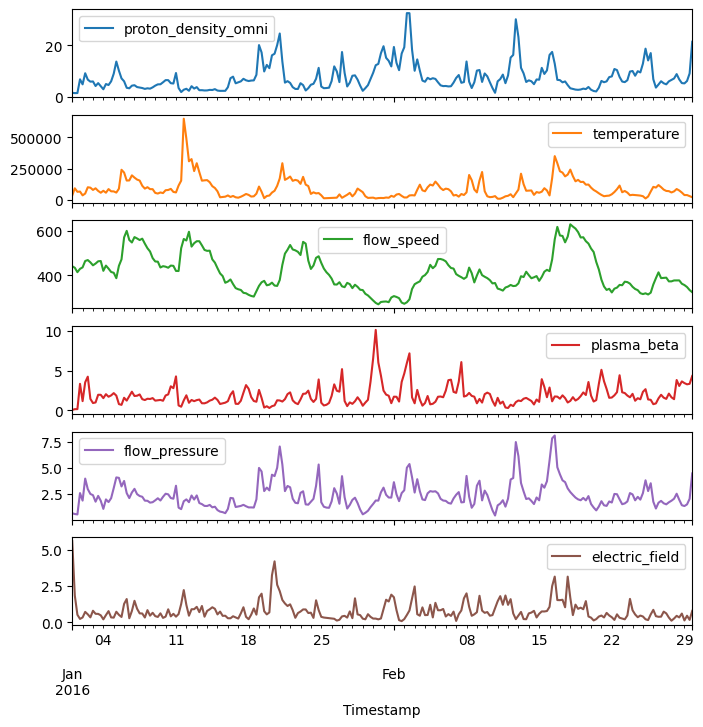

In [162]:
df_omni[:"2017"].plot(subplots=True, figsize=(8,8))
plt.show()

### Reading in Wind data

#### Electron data
6-hour averages, first processed and saved to `.pkl` file in `process_data_wind_electrons.py`

In [163]:
df_electrons = pd.read_pickle('data/processed/wi_elm2_3dp_6hr.pkl')
df_electrons.columns = df_electrons.columns.str.lower()
df_electrons = df_electrons.rename(
    columns={
        'density':'electron_density_wind', 
        'avgtemp':'electron_temperature', 
        'velocity_0':'electron_velocity_0', 
        'velocity_1':'electron_velocity_1',
        'velocity_2':'electron_velocity_2'})
df_electrons.describe()

,electron_density_wind,electron_temperature,electron_velocity_0,electron_velocity_1,electron_velocity_2
count,28.000000,28.000000,28.000000,28.000000,28.000000
mean,3.918948,13.525589,-521.655640,56.169758,-27.322170
std,1.973002,3.089446,63.463963,21.251272,21.948463
min,0.636881,9.328401,-650.537354,-1.827031,-92.456978
25%,2.785547,11.299616,-588.553757,47.698445,-35.357465
50%,3.533674,12.947935,-500.243698,58.441317,-28.995323
75%,4.687625,14.806075,-481.791191,69.129305,-15.044926
max,9.831376,23.853952,-404.157928,102.105614,17.284470


In [164]:
# Checking for missing values
df_electrons.isna().any()

electron_density_wind    False
electron_temperature     False
electron_velocity_0      False
electron_velocity_1      False
electron_velocity_2      False
dtype: bool

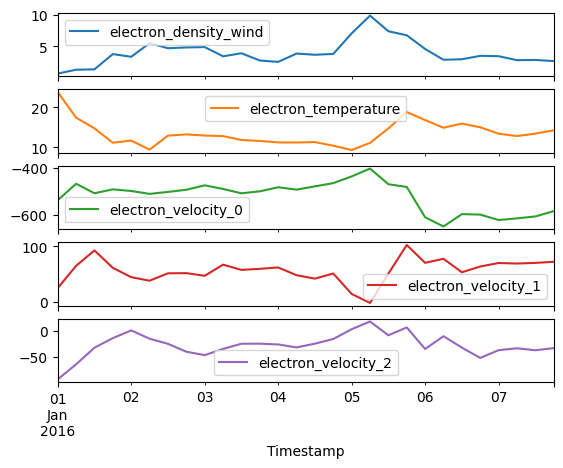

In [165]:
df_electrons[:"2017"].plot(subplots=True)
plt.show()

#### Proton data

6-hour averages, first processed and saved to `.pkl` file in `process_data_omni.py`

In [166]:
df_protons = pd.read_pickle("data/processed/wi_plsp_3dp_6hr.pkl")
df_protons.columns = df_protons.columns.str.lower()
df_protons = df_protons.rename(
    columns={
        'mom.p.density':'proton_density_wind', 
        'mom.p.avgtemp':'proton_temperature', 
        'mom.p.velocity_0':'proton_velocity_0', 
        'mom.p.velocity_1':'proton_velocity_1',
        'mom.p.velocity_2':'proton_velocity_2'})
df_protons.describe()

,proton_density_wind,proton_temperature,proton_velocity_0,proton_velocity_1,proton_velocity_2
count,24.000000,24.000000,24.000000,24.000000,24.000000
mean,5.053257,16.191368,-476.621307,18.726389,-1.895002
std,2.645748,6.326998,57.614410,16.258303,18.800602
min,1.316161,9.789320,-624.581421,-25.493786,-33.543114
25%,3.427820,12.092058,-485.866402,15.841411,-16.259240
50%,4.671601,13.559746,-462.086166,21.331730,-4.370084
75%,5.713732,17.232981,-444.742096,26.637660,11.610149
max,13.190617,29.817408,-398.106445,46.885571,35.991684


In [167]:
# Checking for missing values
df_protons.isna().any()

proton_density_wind    False
proton_temperature     False
proton_velocity_0      False
proton_velocity_1      False
proton_velocity_2      False
dtype: bool

Now that we have the proton density from Wind (assuming this is better to use than that from OMNI for the same time period), we can calculate the ion inertial length $d_i$. This will be used as one method of calculating the Reynolds number of the solar wind. It may also help us to identify the slope of the dissipation range, required for Chuychai's method of obtaining refined estimates of the Taylor scale.

$$d_i=c/\omega_{pi}=V_A/\Omega_I=2.28\times10^5\times\frac{\sqrt{\mu/n_i}}{Z} \text{metres}$$
The thickness of the current sheets that form in turbulent plasma
- $\omega_{i}$ is the (local) proton plasma frequency
- $\Omega_i$ is the ion gyrofrequency
- $\mu$ is the ratio of the ion mass to proton mass
- $Z$ is the charge state
- $n_i$ is the ion number density
- $V_A$ is the Alfven speed

For protons, this reduces to 

$$d_i=2.28\times10^5\times\sqrt{1/n_i} \text{metres}$$

This should be in the range of 100-200km @ 1AU


In [168]:
df_protons["ion_inertial_length"] = ((df_protons.proton_density_wind)**-0.5)*2.28e5

In [169]:
df_protons.ion_inertial_length.describe()

count        24.000000
mean     112655.898438
std       33987.878906
min       62777.253906
25%       95384.248047
50%      105488.179688
75%      123147.576172
max      198737.750000
Name: ion_inertial_length, dtype: float64

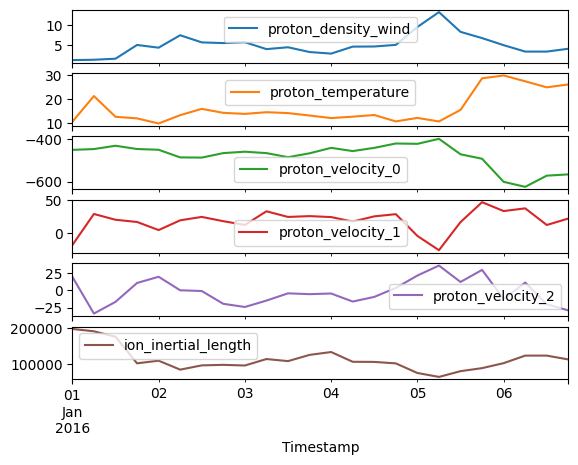

In [170]:
df_protons[:"2017"].plot(subplots=True)
plt.show()

#### Magnetic field data

##### 11Hz data

In [171]:
large_wind_df_hr = pd.read_pickle("data/processed/wi_h2_mfi_hr.pkl")
large_wind_df_hr.describe()

,BF1,BGSE_0,BGSE_1,BGSE_2
count,6.646153e+06,6.646153e+06,6.646153e+06,6.646153e+06
mean,6.773109e+00,-1.601459e+00,8.449951e-01,8.115233e-02
std,2.751566e+00,4.104810e+00,4.188772e+00,3.967027e+00
min,5.505295e-02,-1.272661e+01,-9.870991e+00,-1.375742e+01
25%,4.890481e+00,-4.622535e+00,-2.038769e+00,-1.649748e+00
50%,5.826874e+00,-2.837358e+00,1.462811e+00,2.911074e-01
75%,7.806436e+00,1.471595e+00,3.413829e+00,2.067563e+00
max,1.715050e+01,9.374707e+00,1.578569e+01,1.310275e+01


In [172]:
# Checking for missing values
large_wind_df_hr.isna().any()

BF1       False
BGSE_0    False
BGSE_1    False
BGSE_2    False
dtype: bool

In [173]:
# Working with a single 6-hour interval
length_arr_hr = int(6*60*60*(1/0.091))

wind_df_hr = large_wind_df_hr[:length_arr_hr]
wind_df_hr.shape

(237362, 4)

In [174]:
wind_df_hr

,BF1,BGSE_0,BGSE_1,BGSE_2
Timestamp,,,,
2016-01-01 00:00:00.000,14.943860,5.879855,-1.579370,-13.647411
2016-01-01 00:00:00.091,14.939990,5.890072,-1.591034,-13.637410
2016-01-01 00:00:00.182,14.915795,5.862018,-1.610130,-13.620763
2016-01-01 00:00:00.273,14.936459,5.875757,-1.632746,-13.634788
2016-01-01 00:00:00.364,14.943197,5.881089,-1.634825,-13.639622
...,...,...,...,...
2016-01-01 05:59:59.487,10.363774,4.225235,-9.426723,-0.831916
2016-01-01 05:59:59.578,10.352386,4.167100,-9.432401,-0.914859
2016-01-01 05:59:59.669,10.335396,4.159393,-9.410312,-0.982792


array([<AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>],
      dtype=object)

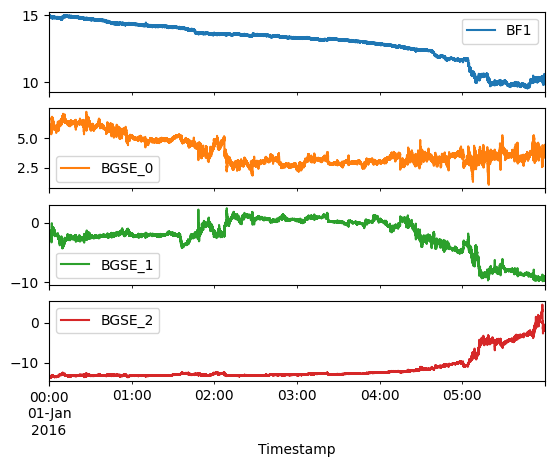

In [175]:
# Takes ~ 3min
wind_df_hr.plot(subplots=True)

##### 0.2Hz data

In [176]:
large_wind_df_lr = pd.read_pickle("data/processed/wi_h2_mfi_lr.pkl")
large_wind_df_lr.describe()

,BF1,BGSE_0,BGSE_1,BGSE_2
count,120960.000000,120960.000000,120960.000000,120960.000000
mean,6.773299,-1.601382,0.845300,0.081179
std,2.750433,4.101557,4.184599,3.961237
min,0.122947,-12.501729,-9.749827,-13.657980
25%,4.891284,-4.619245,-2.035810,-1.643230
50%,5.821594,-2.826296,1.469182,0.290018
75%,7.801711,1.464595,3.409017,2.062738
max,16.993708,9.323752,15.568968,12.924106


In [177]:
# Working with a single 6-hour interval
length_arr_lr = int(6*60*60*0.2)

wind_df_lr = large_wind_df_lr[:length_arr_lr]
wind_df_lr.shape

(4320, 4)

array([<AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>],
      dtype=object)

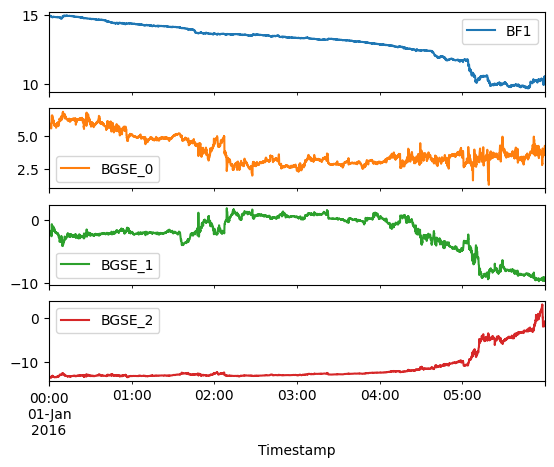

In [178]:
wind_df_lr.plot(subplots=True)

In order to fully implement Chuychai's method, we need the spectral index (slope) of the power law in the dissipation range. *The kinetic range is usually above the spacecraft frame frequency corresponding to the proton inertial length, $f_{pi}=v_{SW}/(2\pi\lambda_{pi}$)* (from Pitna et al. (2021)).

Here we compute a smoothed 3D periodogram for a single high-res interval, then perform a least squares fit of a power law to the inertial and kinetic ranges to determine their slopes and the spectral break.

In [179]:
# Calculate 3D power spectrum
import scipy.signal as signal

def SmoothySpec(a,nums=None):
   b=a.copy()
   if nums is None: nums=2*len(b)//3
   for i in range(nums):
      b[i+1::][:-1] = 0.25*b[i::][:-2]+0.5*b[i+1::][:-1]+0.25*b[i::][2:]
   return b

def fitpowerlaw(ax,ay,xi,xf):
   idxi=np.argmin(abs(ax-xi))
   idxf=np.argmin(abs(ax-xf))
   xx=np.linspace(xi,xf,100)
   z=np.polyfit(np.log(ax[idxi:idxf]),np.log(ay[idxi:idxf]),1);
   p=np.poly1d(z);
   pwrl=np.exp(p(np.log(xx)))
   return z,xx,pwrl

def compute_spectral_stats(np_array, dt, f_min_inertial, f_max_inertial, f_min_kinetic, f_max_kinetic, show=False):
    """ Compute the autocorrelation function for a scalar or vector time series.
    
    ### Args:

    - np_array: Array of shape (1,n) or (3,n)
    - nlags: The number of lags to calculate the ACF up to
    - dt: Cadence of measurements, or time between each sample: one sample every dt seconds

    ### Returns:

    - z_i: Slope in the inertial range
    - z_k: Slope in the kinetic range
    - spectral_break: Frequency of the spectral break between the two ranges

    """
    x_freq = 1/dt

    f_periodogram, power_periodogram_0 = signal.periodogram(np_array[0], fs = x_freq, window="boxcar", scaling="density")
    power_periodogram_0 = (x_freq/2)*power_periodogram_0

    f_periodogram, power_periodogram_1 = signal.periodogram(np_array[1], fs = x_freq, window="boxcar", scaling="density")
    power_periodogram_1 = (x_freq/2)*power_periodogram_1

    f_periodogram, power_periodogram_2 = signal.periodogram(np_array[2], fs = x_freq, window="boxcar", scaling="density")
    power_periodogram_2 = (x_freq/2)*power_periodogram_2

    power_periodogram = (power_periodogram_0 + power_periodogram_1 + power_periodogram_2)/3

    p_smooth = SmoothySpec(power_periodogram) # Takes about 20 seconds

    zk, xk, pk = fitpowerlaw(f_periodogram, p_smooth, f_min_kinetic, f_max_kinetic) # Kinetic range
    zi, xi, pi = fitpowerlaw(f_periodogram, p_smooth, f_min_inertial, f_max_inertial) # Inertial range

    powerlaw_intersection = np.roots(zk-zi)
    spectral_break = np.exp(powerlaw_intersection)

    if show == True:
        plt.semilogy(f_periodogram, power_periodogram, label = "Raw periodogram")
        plt.semilogy(f_periodogram, p_smooth, label = "Smoothed periodogram", color = "cyan")
        plt.semilogy(xi, pi, c = "red", label = "Inertial range power-law fit: $\\alpha$ = {0:.2f}".format(zi[0]))
        plt.semilogy(xk, pk, c = "yellow", label = "Kinetic range power-law fit: $\\alpha$ = {0:.2f}".format(zk[0]))
        plt.semilogx()
        plt.axvline(np.exp(np.roots(zk-zi)), color = "black")
        plt.xlabel('frequency [Hz]')
        plt.ylabel('PSD')
        plt.legend()
        plt.title("Power spectrum")
        plt.grid()
        plt.show()

    return zi[0], zk[0], spectral_break[0]

*Relate the kinetic range above to $t_{di}$ and/or Pitna et al.*

*Maths for calculating breakpoint:*

Each power-law fit is given by the following equation:

$$y =x^me^c$$

This is because we take the log of both sides, we get the formula for a straight line

$$\log(y) = m\log(x)+c$$

We want to find the x-value for which two power-laws are equal. We can do this by subtracting one from the other and finding the value of $\log(x)$ where this subtraction = 0, i.e., the root of the equation.

$$m_1\log(x)+c_1-m_2\log(x)-c_2=0$$

Finally, we take the exponential of this root to get the x-value of the spectral break

$$x = e^{\log(x)}$$

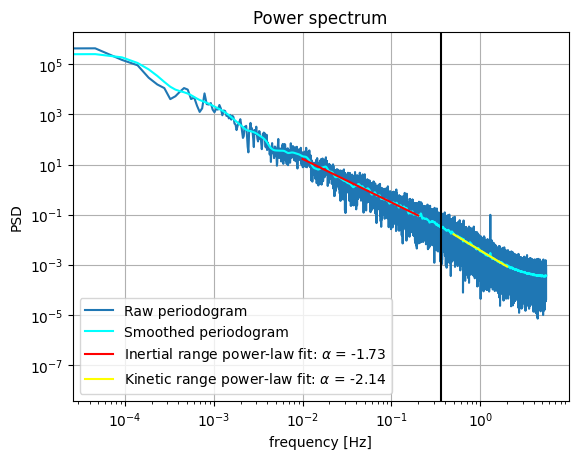

(-1.7345063155894773, -2.1394108557912146, 0.3605737910311339)

In [180]:
compute_spectral_stats(
    np.array([wind_df_hr.BGSE_0, wind_df_hr.BGSE_1, wind_df_hr.BGSE_2]), 
    dt = 0.091, 
    f_min_inertial = 0.01, f_max_inertial = 0.2, 
    f_min_kinetic = 0.5, f_max_kinetic = 2, 
    show=True)

- $\alpha_{i}=-1.73$
- $\alpha_{k}=-2.14$
- $b=0.36$

### ACF function

This is what we use to calculate the correlation scale and Taylor scale. Note that Chuychai et al. did not calculate the ACF directly from the data; they calculated it from $D_2$. Here, we will calculate it directly from the data.

Following function is based off Kevin's `compute_corr.compute_correlation_time_scale.compute_autocorrelation_function()`. Automatically detects whether being fed 1D (scalar) or 3D time series, for which the calculation is as follows (before normalisation)

$$R(\tau)=\frac{1}{3}\times(R_x(\tau)+R_y(\tau)+R_z(\tau))$$

*Should `tsa.acf()` be set to `fft=False`? Default is True. Check for differences in speed.*

In [181]:
def compute_nd_acf(np_array, nlags, dt, show=False):
    """ Compute the autocorrelation function for a scalar or vector time series.
    
    Args:

    - np_array: Array of shape (1,n) or (3,n)
    - nlags: The number of lags to calculate the ACF up to
    - dt: Cadence of measurements, or time between each sample: one sample every dt seconds

    Returns:

    - time_lags: The x-values of the ACF, in seconds, given the cadence of measurements
    - R: The values of the ACF from lag 0 to nlags

    """
    if np_array.shape[0] == 3:
        acf = \
        sm.tsa.acf(np_array[0], fft=False, nlags=nlags) + \
        sm.tsa.acf(np_array[1], fft=False, nlags=nlags) + \
        sm.tsa.acf(np_array[2], fft=False, nlags=nlags)
        acf /= 3

    elif np_array.shape[0] == 1:
        acf = sm.tsa.acf(np_array[0], fft=False, nlags=nlags)

    else:
        raise ValueError("Array is not 3D or 1D. If after a 1D acf, try putting square brackets around the pandas series in np.array()")

    time_lags = np.arange(0, nlags+1)*dt   

    # Optional plotting
    if show == True:

        fig, ax1 = plt.subplots()

        ax1.plot(time_lags, acf)
        ax2 = ax1.twiny()
        ax2.plot(np.arange(0, nlags+1), acf)

        ax1.set_xlabel('Lag (s)')
        ax2.set_xlabel('Lag ($\\tau$)')
        ax1.set_ylabel('Autocorrelation')
        plt.show()

    return time_lags, acf

Scalar version

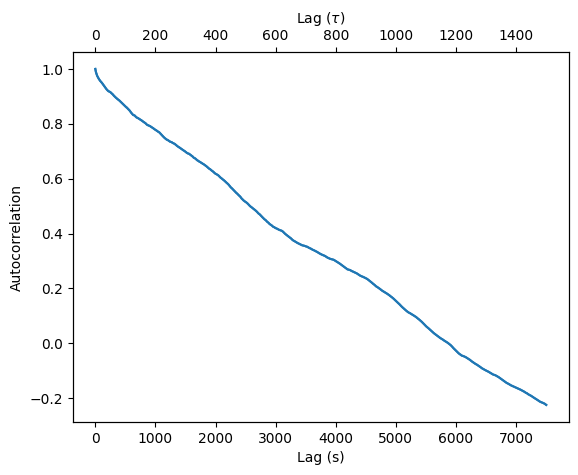

In [182]:
time_lags_lr, r_scalar_lr = compute_nd_acf(np.array([wind_df_lr.BGSE_0]), nlags=1500, dt = 5, show = True)

Vector version (same function, automatically detects). The following low-res ACF will be used for calculating the outer scale

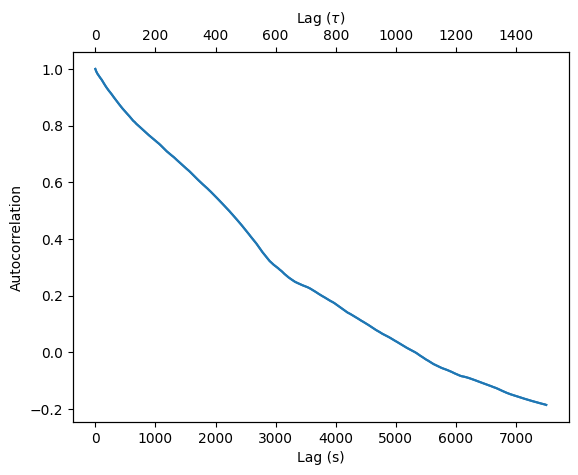

In [183]:
time_lags_lr, r_vec_lr = compute_nd_acf(np.array([wind_df_lr.BGSE_0, wind_df_lr.BGSE_1, wind_df_lr.BGSE_2]), nlags=1500, dt = 5, show = True)

The following high-res ACF will be used for calculating the Taylor scale. *This takes about 2.5 minutes to run*. **Look into faster codes like Fortran**

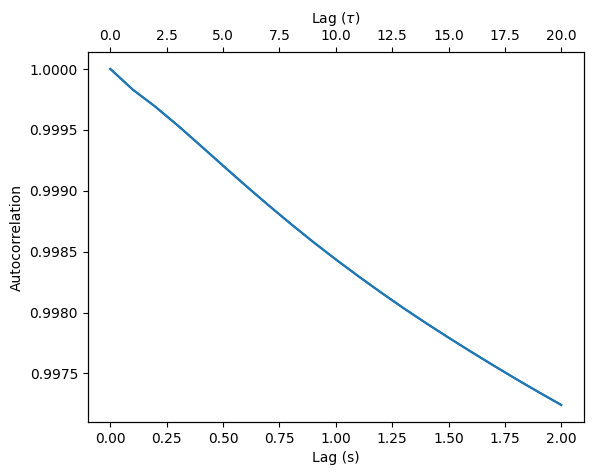

In [20]:
time_lags_hr, r_vec_hr = compute_nd_acf(np.array([wind_df_hr.BGSE_0, wind_df_hr.BGSE_1, wind_df_hr.BGSE_2]), nlags=20, dt = 0.1, show = True)

### Correlation scale functions

Names for $\tau_c$:
- Outer scale
- (Longitudinal) integral scale
- Correlation scale

Firstly, using Kevin's function for computing outer scale using $1/e$ trick:

If we set $f(\tau)=\exp(-\tau/\tau_c)=e^{-1}$, then $\tau_c=\tau$.

Kevin referred to the value calculated from this method as `estimate` and `Correlation_timescale_est`.

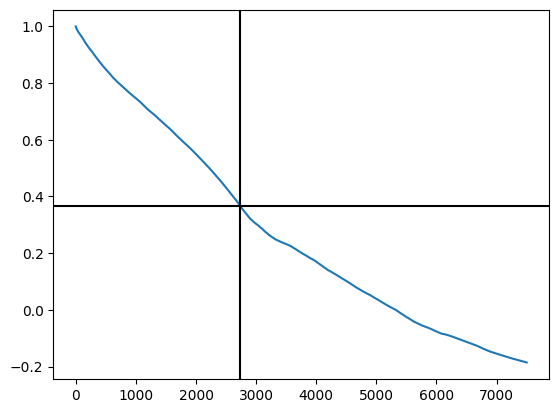

2732.171

In [184]:
from utils import estimate_correlation_scale as compute_outer_scale_exp_trick
compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, show = True)

Secondly, adapting Kevin's function for computing outer scale using exponential fit, from `compute_correlation_time_scale()`. A function of the following form is fit to the ACF $R(\tau)$.

$$f(\tau)=\exp(-\tau/\tau_c)$$

"The extent of the autocorrelation to fit on was determined to be 1000 seconds worth of lag, through some trial and error and inspection of plotted results" (de Lange, 2021). Kevin referred to the value calculated from this method as `lambda_c` and `Correlation_timescale`.

**Do 1/e method first, and then fit to this much data**

In [194]:
from utils import exp_fit

def compute_outer_scale_exp_fit(time_lags, acf, seconds_to_fit, show=False):

    dt = time_lags[1]-time_lags[0]
    num_lags_for_lambda_c_fit = int(seconds_to_fit/dt)
    c_opt, c_cov = curve_fit(
        exp_fit, time_lags[:num_lags_for_lambda_c_fit], acf[:num_lags_for_lambda_c_fit], p0=1000)
    lambda_c = c_opt[0]

    # Optional plotting
    if show == True:
        ax = plt.gca()
        #ax.set_ylim(-.2, 1.2)
        plt.plot(time_lags, acf, label = "Autocorrelation")
        plt.plot(
            np.array(range(int(seconds_to_fit))),
            exp_fit(
                np.array(range(int(seconds_to_fit))),
                *c_opt
            ),
            'r-', 
            label = "Exponential fit")
        # box_color = 'grey' if lambda_c > 50 else 'red'
        # ax.text(time_lags[-1]*(5/10), 0.9, f'$\lambda_c$: {round(lambda_c, 1)}s', style='italic', fontsize=10,
        #         bbox={'facecolor': box_color, 'alpha': 0.5, 'pad': 10})
        ax.set_xlabel('Lag (s)')
        #ax2.set_xlabel('Lag ($\\tau$)')
        plt.legend()
        plt.show()
    
    return lambda_c


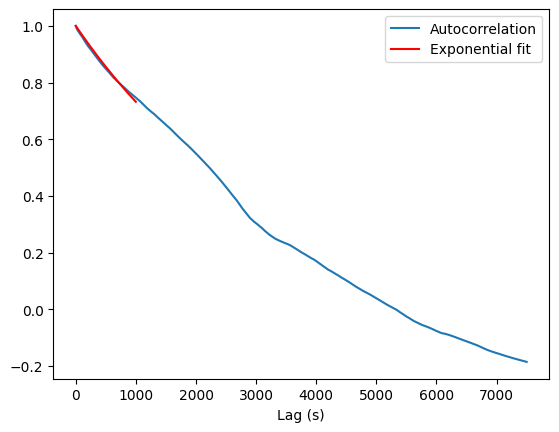

3206.47402194443

In [195]:
compute_outer_scale_exp_fit(time_lags_lr, r_vec_lr, seconds_to_fit = 1000, show = True)

Finally, creating a function for computing outer scale as integral of the ACF. This formula comes from the re-arrangement of the simple exponential that a time series follows if it approximates a Markov process (Batchelor, 1970). 

$$\tau_C=\int_0^\infty R(\tau)d\tau$$

In [209]:
def compute_outer_scale_integral(time_lags, r_vec, show = False):
    
    dt = time_lags[1]-time_lags[0]  
    idx = np.argmin(np.abs(r_vec_lr))
    int = np.sum(r_vec_lr[:idx])*dt

    # Optional plotting
    if show == True:
        ax = plt.gca()
        #ax.set_ylim(-.2, 1.2)
        plt.plot(time_lags, r_vec, label = "Autocorrelation")
        plt.fill_between(time_lags, 0, r_vec, where=r_vec > 0)
        # box_color = 'grey' if lambda_c > 50 else 'red'
        # ax.text(time_lags[-1]*(5/10), 0.9, f'$\lambda_c$: {round(lambda_c, 1)}s', style='italic', fontsize=10,
        #         bbox={'facecolor': box_color, 'alpha': 0.5, 'pad': 10})
        ax.set_xlabel('Lag (s)')
        plt.legend()
        plt.show()
    
    return int

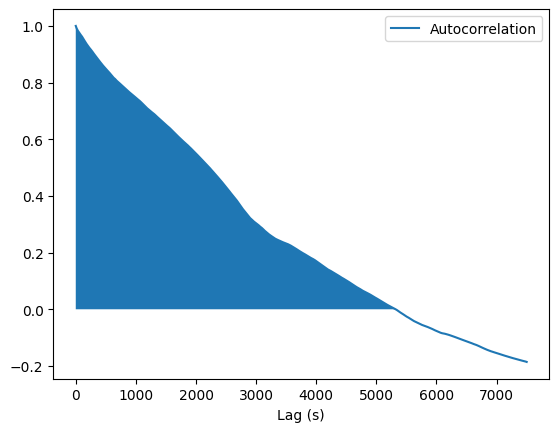

2276.8090899069066

In [210]:
compute_outer_scale_integral(time_lags_lr, r_vec_lr, show = True)

### Taylor scale function

Taylor microscale (time domain) = $\tau_{TS}$ = radius of curvature of ACF at the origin. 

Can calculate using second derivative of the ACF at the origin, but this is not commonly done as it is very sensitive to behaviour at the origin. Here we use the parabolic fit method. This code is adapted from Kevin's `compute_taylor_time_scale()`.

Previously this function took the number of seconds to fit the parabola over as the input, and then converted this to the number of lags. (This was chosen to be 2 seconds = 20 lags.) In line with Chuychai's method, this function now takes the number of lags `tau_fit` as input directly.

In [26]:
from utils import para_fit

def compute_taylor_scale(time_lags, acf, tau_fit, show=False):
    """Compute the Taylor microscale
    
    Args:

    - time_lags: The x-values of the ACF, in seconds, given the cadence of measurements
    - acf: The y-values of the ACF
    - tau_fit: number of lags to fit the parabola over
    """

    # If using seconds_fit as the fitting argument instead:

    # dt = time_lags[1]-time_lags[0]
    # tau_fit = int(seconds_fit/dt)

    t_opt, t_cov = curve_fit(
        para_fit,
        time_lags[:tau_fit],
        acf[:tau_fit],
        p0=10)
    lambda_t = (-1*t_opt[0])**-.5

    # Optional plotting
    if show == True:
        ax = plt.gca()
        ax.set_ylim(0, 1.2)
        plt.plot(time_lags, acf, label = "Autocorrelation", lw=2)
        plt.plot(
            np.array(range(int(1.2*lambda_t))),
            para_fit(np.array(range(int(1.2*lambda_t))), *t_opt),
            '-y',
            label = "Parabolic fit")
        #plt.axhline(0, color = 'black')
        ax.vlines(0, ymin = 0.95, ymax = 1.05, color = 'green')
        ax.vlines(tau_fit*(time_lags[1]-time_lags[0]), ymin = 0.92, ymax = 1.02, color = 'green')
        ax.set_xlabel('Lag (s)')
        #ax.set_xlabel('Lag ($\\tau$)')
        plt.legend()
        plt.show()

    return lambda_t


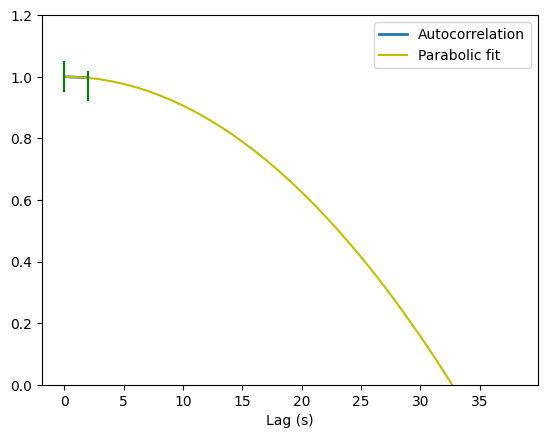

32.69005497411216

In [27]:
compute_taylor_scale(time_lags_hr, r_vec_hr, tau_fit=20, show = True)

#### Chuychai (Richardson) extrapolation method

Calculate Taylor scale from parabolic fit for a range of values of $\tau_{fit}$, up to $\tau_{max}$. Plot these values as a function of $\tau_{fit}$, then draw a straight line through the points back to `tau_{fit}`=0. For the ACE data, Chuychai et al. used the range $4<\tau_{fit}<25$. For PSP data, Phillips et al. (2022) used the range $3<\tau_{fit}<20$. (In this study, the authors also reported an error for each Taylor scale calculation as the standard deviation given by the fit. )

Chuychai's notation:
- $\tau_{fit}$: parabola is fitted from $\tau=0$ to $\tau=\tau_{fit}$
- $\tau_{fit}^{est}(\tau_{fit})$ = estimate of $\tau_{TS}$ for a given value of $\tau_{fit}$
- $\tau_{TS}^{extra}$: estimate obtained by the extrapolation method
- $q$ = dissipation scale index
- $\tau_{d}$ = Kolmogorov scale (time domain) - point where the inertial range terminates and the spectrum steepens

How do we find the upper value, $\tau_{max}$? This is investigated in Fig. 5 of Chuychai. Weygand et al. (2007) show an example of reaching a stable estimate as $\tau_{max} increases, but Chuychai shows that this is dependent on the spectral index.

In [40]:
# Think about adding consistency check that compares t_est with t_min
# Look at case studies of extreme values of t_est - see what these extrapolation plots are doing 

def compute_taylor_chuychai(time_lags, acf, tau_min, tau_max, show=False):
    """Compute a refined estimate of the Taylor microscale using a linear extrapolation method from Chuychai et al. (2014).
    
    Args:

    - time_lags: The x-values of the ACF, in seconds, given the cadence of measurements
    - acf: The y-values of the ACF
    - tau_min: Minimum value for the upper lag to fit the parabola over. This should not be too small, because the data has finite time resolution and there may be limited data available at the shortest time lags. (You will see divergent behaviour if this happens.)
    - tau_max: Maximum value for the upper lag to fit the parabola over
    - q: Slope of the dissipation range
    """

    tau_fit = np.arange(tau_min, tau_max+1)
    tau_ts = np.array([])

    for i in tau_fit:
        lambda_t = compute_taylor_scale(time_lags, acf, tau_fit=i, show=False)
        tau_ts = np.append(tau_ts, lambda_t)

    # Performing linear extrapolation back to tau_fit = 0
    z = np.polyfit(x=tau_fit, y=tau_ts, deg=1)
    f = np.poly1d(z)

    other_x = np.arange(0, tau_max+1)
    other_y = f(other_x)

    # Applying correction factor
    # FROM CHUYCHAI

    # Optional plotting
    if show == True:
        plt.plot(tau_fit, tau_ts, color="blue", label = "Range over which $\\tau_{TS}$ was calculated")
        plt.plot(other_x, other_y, color="black", label = "Linear extrapolation to $\\tau_{fit}$=0", ls = '--')
        plt.xlim(0, 30)
        plt.xlabel("$\\tau_{fit}$")
        plt.ylabel("$\\tau_{TS}^{est}$")
        plt.legend()
        plt.show()

    return other_y[0]


We can compare the following to Fig. 4 in Chuychai, and less directly to Figs. 5 and 7 in Weygand et al. (2007)

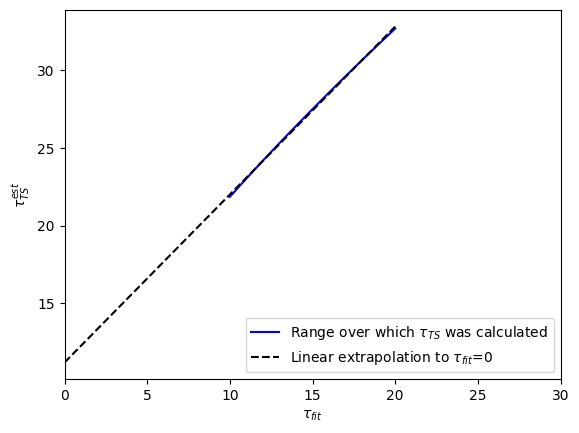

11.184156257064256

In [60]:
compute_taylor_chuychai(time_lags_hr, r_vec_hr, tau_min=10, tau_max=50, show = True)

**Do not go below 1 second for the fit, go up to 5-10 seconds +, express axes in terms of seconds**

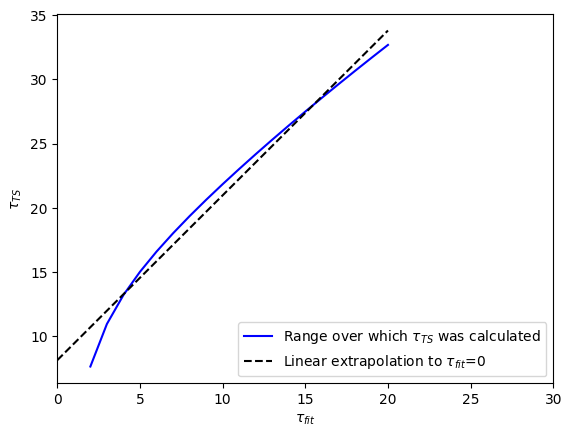

8.153484320981011

In [30]:
compute_taylor_chuychai(time_lags_hr, r_vec_hr, tau_min=10, tau_max=20, show = True)

As noted by Chuychai et al., "it is not practical to compute this limit because the data has a finite time resolution and there may be limited data available at the shortest time lags".

This paper also notes that we are more likely to reach a stable estimate of $\lambda_{TS}$ after extrapolation when we have a steep spectral index $q$ in the dissipation range. A smaller $q$ means we do not obtain a stable estimate.

Chuychai et al. then developed an additional correction factor "which can be used when estimates of the [slope of the] high-frequency spectrum of the signal are available in some way, whether it be observations, theory, or an informed guess". The equation for this final estimate is given in Eq. 10 of the paper.

## Constructing the final dataframe

In [213]:
# Splitting entire dataframe into a list of 6-hour intervals

length_arr_lr = int(6*60*60*0.2)
length_arr_hr = int(6*60*60*11)

n_intervals_lr = int(np.floor(len(large_wind_df_lr)/length_arr_lr))
wind_df_lr_list = np.split(large_wind_df_lr[:n_intervals_lr*length_arr_lr], n_intervals_lr)

n_intervals_hr = int(np.floor(len(large_wind_df_hr)/length_arr_hr))
wind_df_hr_list = np.split(large_wind_df_hr[:n_intervals_hr*length_arr_hr], n_intervals_hr)

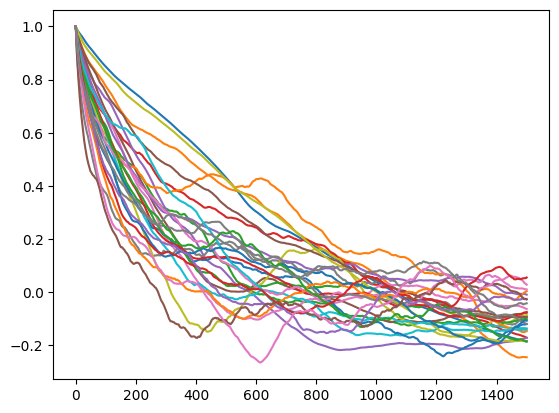

In [214]:
# Computing ACFs each low-res interval

acf_lr_list = []

for i in np.arange(len(wind_df_lr_list)):

    time_lags_lr, acf = compute_nd_acf(
        np.array([wind_df_lr_list[i].BGSE_0, wind_df_lr_list[i].BGSE_1, wind_df_lr_list[i].BGSE_2]), 
        nlags = 1500, 
        dt=5)

    acf_lr_list.append(acf)

for acf in acf_lr_list:
    plt.plot(acf)

In [215]:
# Computing ACFs and spectral statistics for each high-res interval

acf_hr_list = []
inertial_slope_list = []
kinetic_slope_list = []
spectral_break_list = []

# Limiting no. of intervals to calculate as computationally expensive
for i in np.arange(2):

    time_lags_hr, acf = compute_nd_acf(
        np.array([wind_df_hr_list[i].BGSE_0, wind_df_hr_list[i].BGSE_1, wind_df_hr_list[i].BGSE_2]), 
        nlags = 20, 
        dt=0.1)
    
    acf_hr_list.append(acf)

    slope_i, slope_k, break_s = compute_spectral_stats(
        np.array([wind_df_hr.BGSE_0, wind_df_hr.BGSE_1, wind_df_hr.BGSE_2]), 
        dt = 0.091, 
        f_min_inertial = 0.01, f_max_inertial = 0.2, 
        f_min_kinetic = 0.5, f_max_kinetic = 2, 
        show=True)

    inertial_slope_list.append(slope_i)
    kinetic_slope_list.append(slope_k)
    spectral_break_list.append(break_s)

for acf in acf_hr_list:
    plt.plot(acf)

In [34]:
# Computing scales for each interval

corr_scale_exp_fit_list = []
corr_scale_exp_trick_list = []
corr_scale_int_list = []

for acf in acf_lr_list:
    corr_scale_exp_fit = compute_outer_scale_exp_fit(time_lags_lr, acf, 1000, show = False)
    corr_scale_exp_fit_list.append(corr_scale_exp_fit)

    corr_scale_exp_trick = compute_outer_scale_exp_trick(time_lags_lr, acf)
    corr_scale_exp_trick_list.append(corr_scale_exp_trick)

    corr_scale_int = compute_outer_scale_integral(time_lags_lr, acf)
    corr_scale_int_list.append(corr_scale_int)

taylor_scale_list = []

for acf in acf_hr_list:
    taylor_scale = compute_taylor_chuychai(time_lags_hr, acf, 4, 20)
    taylor_scale_list.append(taylor_scale)


Area (trapz) = 2045.8793576808318
Area (simps) = 2045.878830716037
Area (trapz) = 1884.658556382128
Area (simps) = 1884.6570350901345
Area (trapz) = 669.0021657439609
Area (simps) = 668.999989638377
Area (trapz) = 1552.0985755013435
Area (simps) = 1552.091248835407
Area (trapz) = 324.3972943352069
Area (simps) = 324.39184851043217
Area (trapz) = 720.2383058153193
Area (simps) = 720.2361407024703
Area (trapz) = 717.9895341783548
Area (simps) = 717.988176607121
Area (trapz) = 896.5569662956422
Area (simps) = 896.5523498487421
Area (trapz) = 446.2590603387274
Area (simps) = 446.2519408875103
Area (trapz) = 278.8811287188897
Area (simps) = 278.87609293413385
Area (trapz) = 447.9673929747534
Area (simps) = 447.9563925050434
Area (trapz) = 2012.1808882139158
Area (simps) = 2012.177994682779
Area (trapz) = 764.4398762518764
Area (simps) = 764.437668342257
Area (trapz) = 824.7952370969767
Area (simps) = 824.7910244076076
Area (trapz) = 1507.129159228703
Area (simps) = 1507.1263958683487
Area (

In [35]:
# Joining lists of scales together into a dataframe

df_scales = pd.DataFrame({
    'corr_scale_exp_fit':corr_scale_exp_fit_list, 
    'corr_scale_exp_trick':corr_scale_exp_trick_list,
    'corr_scale_int':corr_scale_int_list
    # ,
    # 'taylor_scale':taylor_scale_list
    })
df_scales = df_scales.join(pd.DataFrame({"taylor_scale":taylor_scale_list}))

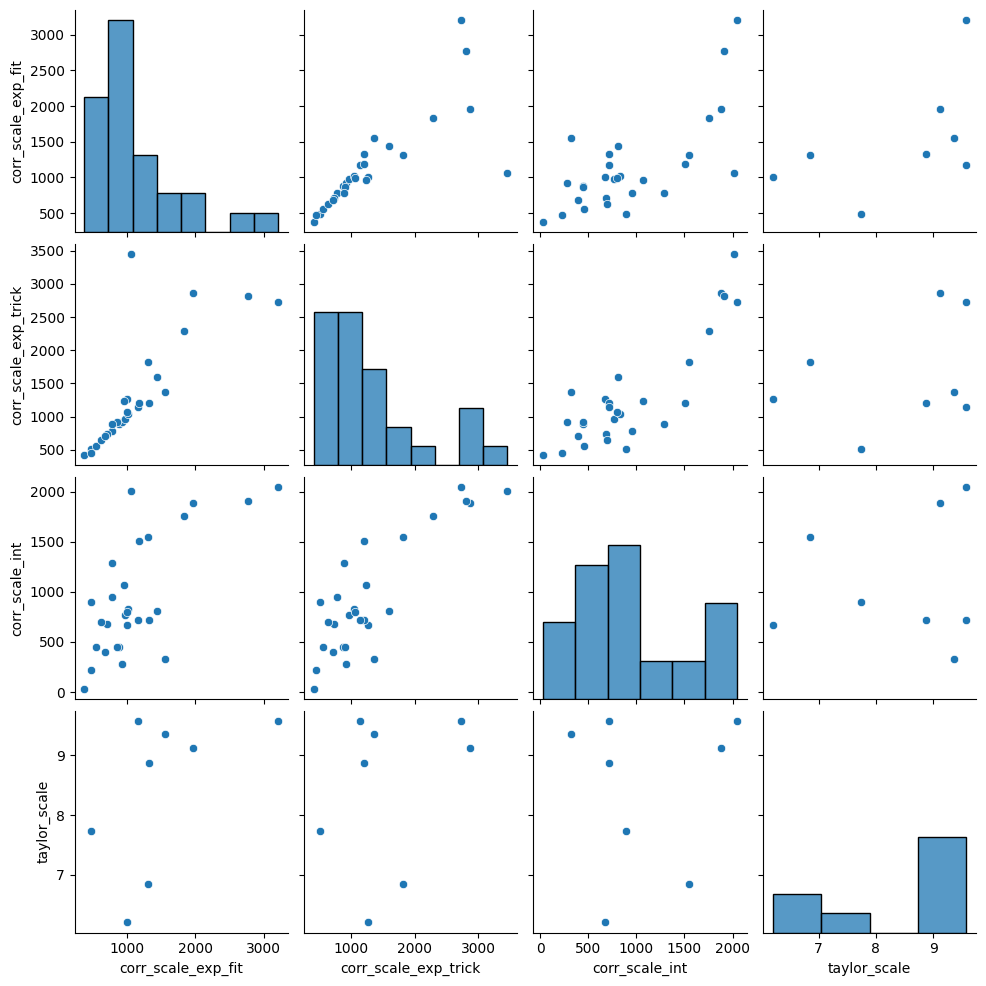

In [36]:
import seaborn as sns
sns.pairplot(df_scales)

In [37]:
# Joining other data together into a dataframe

df_non_scales = join_dataframes_on_timestamp(join_dataframes_on_timestamp(df_omni, df_electrons), df_protons)
df_non_scales = df_non_scales.reset_index()

# Joining all data together into a dataframe
df_complete = df_non_scales.join(df_scales)
df_complete

df_complete.to_csv("data/processed/df_complete.csv")

**Add inertial and kinetic range slopes, spectral breakpoint**

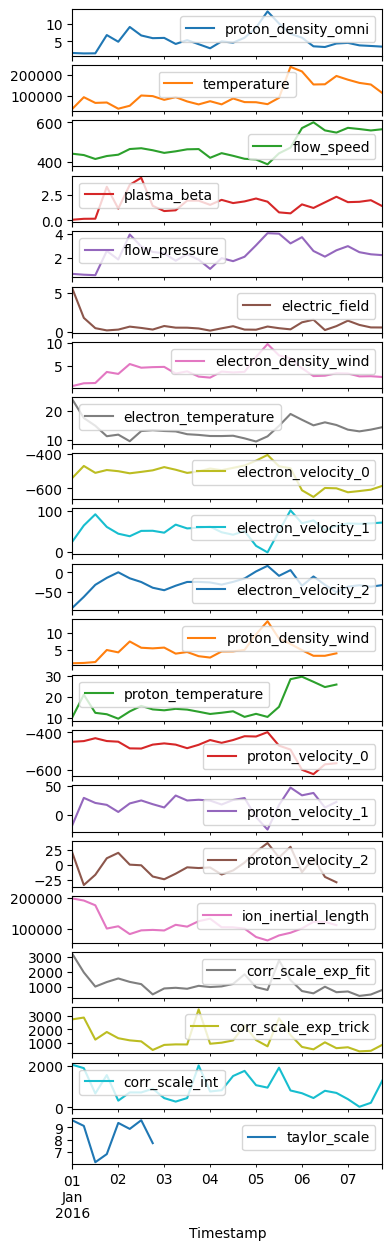

In [38]:
df_complete[df_complete.Timestamp<"2016-01-8"].plot(x = "Timestamp", subplots=True, figsize = (4, 15))
plt.show()

Plot from R shows nice ordering of correlations - but note that emphasis should be placed on taylor scale (as well as beautifying labels):

![title](corr_matrix_Rplot.png)